In [13]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, uniform, kstest

In [14]:
import os
print(os.getcwd())

C:\Users\niall\OneDrive - University of Southampton\PhD


In [15]:
random_seed = 97

**Function for computing W and d for A matrix**

In [17]:
# Function: computing W and d (diagonal entries)

def A_matrix(A_dim=100, W_tilde_mean=0, W_tilde_scale=1, exp_rate=1):
    
    # IID N(W_tilde_mean, W_tilde_scale) entries
    W_tilde = np.random.normal(loc = W_tilde_mean, 
                               scale = W_tilde_scale, 
                               size = (A_dim, A_dim))
    
    # QR decomposition
    Q, R = np.linalg.qr(W_tilde)
    W = Q

    # Diagonal matrix elements (using Exp(lambda))
    exp_scale = 1/exp_rate
    d = np.random.exponential(scale=exp_scale, size=A_dim)
    
    return W, d

**Function for computing sample solution x**

In [23]:
# Function: drawing solution vectors x^(i) from prior mu_0 = N(0, A^-1)

def sample_solution_x(W, d):
    
    # Inverse & squareroot of D matrix elements for transforming std. normal samples
    inv_sqrt_d = 1.0 / np.sqrt(d)
    B = W @ np.diag(inv_sqrt_d)
    
    # Std. normal samples
    z = np.random.normal(size=(W.shape[0], 1))
    
    # Transform
    solution_x = B @ z
    
    return solution_x

**Randomised Post-Iteration Algorithm**

In [119]:
# Function: Randomised Postiterations (Algorithm 1)

def rand_post_iter(A, b, x0, eps_1, eps_2, max_iter):
    
    """
    Inputs: 
    A: Matrix A (n x n)
    b: Vector b (n x 1)
    x0: Initial solution
    eps_1: Threshold 1
    eps_2: Threshold 2
    max_iter: Maximum number of post-iterations

    Returns:
    x_solution: Solution from convergence after Threshold 1 (n x 1)
    L_matrix: Constructed from phi*search-directions (n x post-iterations)
    P_m: Matrix of unnormalised search directions (from post-iterations)
    z: Random normal sample (mean:1, sd: phi_list)
    
    """
    
    # Initialisation
    k = 0
    k2 = 0 # For number of post-iterations

    # Initial residual and search direction
    r = b - A @ x0
    r_list = [r]
    psi_list =[]
    p = r.copy()
    p_list = [p]
    
    x = x0.copy()
    x_list = [x0]

    # L: list storing phi*search-direction
    L = []

    # Flags for if L is empty and when x_solution is found
    appended_to_L = False
    x_solution = None

    # CG LOOP
    # to find x* with ||r|| <= eps_1
    while True:
        
        Ap = A @ p
        rTr = r.T @ r
        alpha = (rTr) / (p.T @ Ap)
        
        x_new = x + (alpha * p)
        x_list.append(x_new)

        # CG Residual
        r_new = r - (alpha * Ap)
        
        # Exact Residual if it helps
        # r_new = b - A @ x_new
        
        beta = (r_new.T @ r_new) / rTr

        # New search direction (option for regular CG update)
        p_new = r_new # + beta * p

        # Orthogonilising search directions
        for p_i in p_list:
            p_new = p_new - (p_new.T @ A @ p_i)/(p_i.T @ A @ p_i) * p_i
        
        p_list.append(p_new)

        # Checking for Threshold 1: save x_solution if converged
        if (x_solution is None) and (np.linalg.norm(r_new) <= eps_1):
            
            x_solution = x_new.copy()
#             print(f"Converged: less than eps_1 at iteration {k}")

        # Post-iterations: once x_solution is found and Threshold 2 not met
        if (x_solution is not None) and (np.linalg.norm(r_new) > eps_2):
            
            psi = alpha.copy()
            psi_list.append(psi)
            # print("Alpha = ", alpha, "at K = ", k)
            # print("Psi = ", psi)
            L.append(psi*p)
            # print("k2 = ", k2)

            k2 += 1
            appended_to_L = True

        if k2 == max_iter:
#             print("Hit maximum iterations")
            break
            
        elif (np.linalg.norm(r_new) <= eps_2):
#             print(f"Converged: less than eps_2 at iteration {k}")
            break
        
        x = x_new
        r = r_new
        p = p_new
        k += 1

    # Just in case Threshold 1 and 2 are reached at same time (adds one post-iteration)
    if not appended_to_L:
#        print("No directions added to L")
        psi = alpha 
        L.append(psi * p)
    
    # Constructing L matrix from list
    L_matrix = np.column_stack(L)
#     print("L dimensions:", L_matrix.shape)

    # Storing post-iteration search directions
    P_m = np.hstack(p_list[-k2:])
    
    # Random N(1, phi) 
    z = np.random.normal(1, psi_list).reshape(-1, 1)
    
    return x_solution, L_matrix, P_m, z

**Simulation based calibration routine (only currently works with specifying number of post-iterations)**

Can access all CDF values from post-iterations 1 -> max_iterations

In [48]:
def sim_based_cal( 
    x0, 
    eps_1, 
    eps_2,
    max_iter,
    A_dim = 100, 
    W_tilde_mean = 0, 
    W_tilde_scale = 1, 
    exp_rate = 1,
    n_sim = 1,
):

    """
    ---------
    Inputs:
    ---------
    x0: initial solution
    eps_1: Threshold 1
    eps_2: Threshold 2
    max_iter: maximum number of post-iterations
    A_dim: dimension of matrix A
    W_tilde_mean: mean of W for constructing A
    W_tilde_scale: scale parameter of w for constructing A
    exp_rate: rate of exponential variable for constructing A
    n_sim: number of simulations 
    ---------
    Returns:
    ---------
    t_array: numpy array containing CDF values from simulations - Dimension: Number of simulations x Number of post-iterations x 1
    
    """
    # List for storing CDF values for final array
    t_sim = []

    # Fixed random projection vector
    w = np.random.normal(loc = 0, scale=1, size=A_dim)
    
    # Computing fixed A/W/d for entire experiment
    W, d = A_matrix(A_dim, W_tilde_mean, W_tilde_scale, exp_rate)
    A = W @ np.diag(d) @ W.T

    # Loop: number of simulations
    for i in range(n_sim):

        # Stores CDF values
        t_iter = []
        
        # Sampled solution
        x_star = sample_solution_x(W, d)
#         print('X Star: ', x_star)
        b = A @ x_star
        
        x_solution, L_matrix, P_m, z = rand_post_iter(A, b, x0, eps_1, eps_2, max_iter)
        
        for post_iters in range(max_iter):
            
            x_solution_rand = x_solution + P_m[:, :post_iters+1] @ z[:post_iters+1]
#             print('Random X Solution: ',  x_solution_rand)
            
            L = L_matrix[:, :post_iters+1]
#             print('L Matrix: ', L)

            # CDF computations
            numerator = w.T @ (x_solution_rand - x_star)
            denominator = np.sqrt(w.T @ L @ L.T @ w)
            
            # print('Numerator: ', numerator)
            # print('Denominator: ', denominator)
            
            cdf = norm.cdf(numerator/denominator)
            t_iter.append(cdf)
            
        t_sim.append(t_iter)
 
    t_array = np.array(t_sim)
    
    return t_array

**Examples**

In [135]:
np.random.seed(204)

t_values = sim_based_cal( 
        x0 = np.zeros((100,1)), 
        eps_1 = 1e-3,
        eps_2 = 1e-12,
        max_iter = 20,
        A_dim = 100, 
        W_tilde_mean = 0, 
        W_tilde_scale = 1, 
        exp_rate = 1,
        n_sim = 10000
)

In [137]:
t_values.shape

(10000, 20, 1)

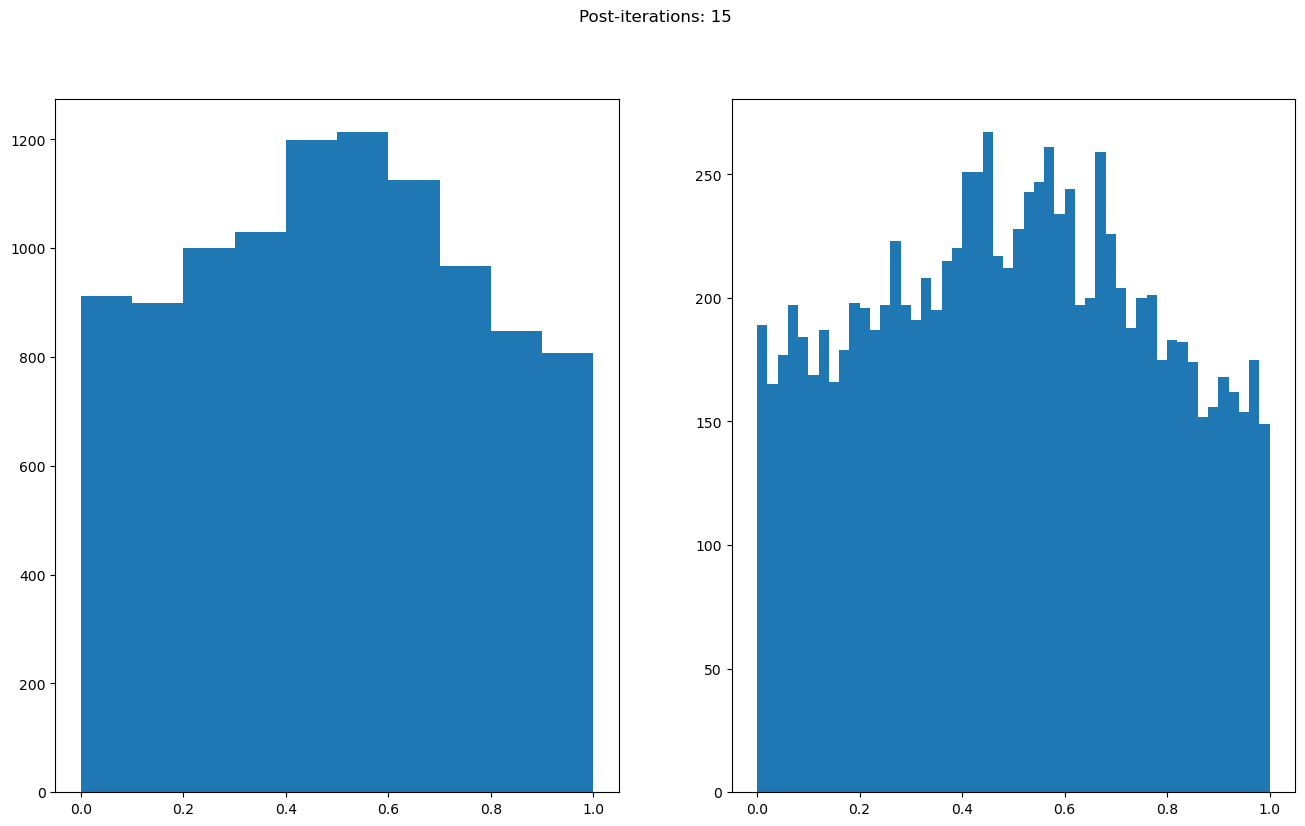

In [145]:
# Choose the 1:max_iter
Post_Iteration_Number = 15
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
fig.suptitle(f'Post-iterations: {Post_Iteration_Number}')
ax1.hist(t_values[:, Post_Iteration_Number-1, :], 10)
ax2.hist(t_values[:, Post_Iteration_Number-1, :], 50);

**KS Statistic Plot**

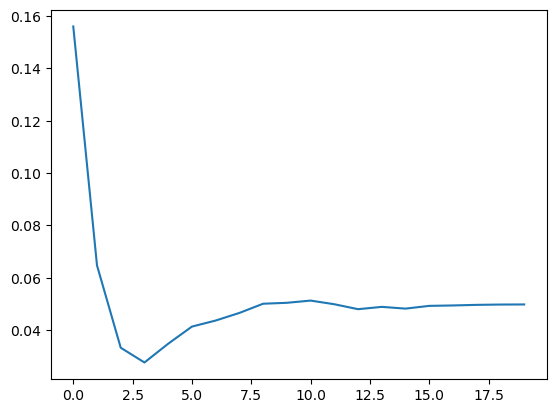

In [109]:
ks_stat = []

for i in range(20):
    ks_stat.append(kstest(t_values[:, i, :], uniform.cdf)[0][0])

plt.plot(ks_stat)

**Everything below is just the code I used to make a GIF of the histograms**

In [17]:
import imageio
directory = "hist_m_post_iter"
os.makedirs(directory, exist_ok=True)

In [84]:
data_size = 100

t_list = []

for i in range(1,40):
    
    np.random.seed(random_seed)

    t_list.append(sim_based_cal( 
        x0 = np.zeros((data_size,1)), 
        eps_1 = 1e-3, 
        eps_2 = 1e-20,
        max_iter=i,
        A_dim = data_size, 
        W_tilde_mean = 0, 
        W_tilde_scale = 1, 
        exp_rate = 1,
        n_sim = 1
    ))

In [23]:
filenames = []
for i in range(1, 40):
    
    plt.figure()
    plt.hist(t_list[i-1], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Post-Iterations: {i+1}')
    plt.xlabel('CDF')
    plt.ylabel('Frequency')

    filename = f'frame_{i}.png'
    filename = os.path.join(directory, f'frame_{i}.png')
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

In [25]:
with imageio.get_writer('histogram_evolution_m_post_iter.gif', mode='I', duration=5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\niall\AppData\Local\Temp\ipykernel_20612\4082719691.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


**Varying $\epsilon_2$ between 1e-4 and 1e-12, $\epsilon_1$ fixed at 1e-3**

In [85]:
directory = "hist_eps2_iter"
os.makedirs(directory, exist_ok=True)

In [86]:
data_size = 100
eps2_list = np.logspace(-4, -12, num=30)
t_list = []

for index, eps2 in enumerate(eps2_list):
    
    np.random.seed(random_seed)

    t_list.append(sim_based_cal( 
        x0 = np.zeros((data_size,1)), 
        eps_1 = 1e-3, 
        eps_2 = eps2,
        max_iter=200,
        A_dim = data_size, 
        W_tilde_mean = 0, 
        W_tilde_scale = 1, 
        exp_rate = 1,
        n_sim = 1000
    ))
    
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


(array([ 95., 114.,  95., 111.,  68.,  79.,  88., 113., 126., 111.]),
 array([0.00842263, 0.10674507, 0.20506751, 0.30338995, 0.40171239,
        0.50003483, 0.59835727, 0.6966797 , 0.79500214, 0.89332458,
        0.99164702]),
 <BarContainer object of 10 artists>)

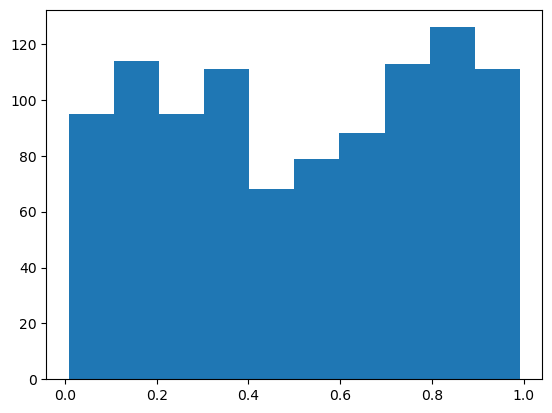

In [93]:
plt.hist(t_list[-1])

In [94]:
filenames = []
for i, eps in enumerate(eps2_list):
    
    plt.figure()
    plt.hist(t_list[i], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Epsilon: {eps}')
    plt.xlabel('CDF')
    plt.ylabel('Frequency')

    filename = f'frame_{i}.png'
    filename = os.path.join(directory, f'frame_{i}.png')
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

In [95]:
with imageio.get_writer('histogram_evolution_eps2.gif', mode='I', duration=2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

C:\Users\niall\AppData\Local\Temp\ipykernel_20612\2123436674.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [96]:
for i in t_list:
    print(kstest(i, uniform.cdf))

KstestResult(statistic=array([0.04353614]), pvalue=array([0.04382957]), statistic_location=array([0.26246386]), statistic_sign=array([1.]))
KstestResult(statistic=array([0.04946988]), pvalue=array([0.0144658]), statistic_location=array([0.34053012]), statistic_sign=array([1.]))
KstestResult(statistic=array([0.06648207]), pvalue=array([0.00027529]), statistic_location=array([0.24251793]), statistic_sign=array([1.]))
KstestResult(statistic=array([0.03711086]), pvalue=array([0.12412072]), statistic_location=array([0.93388914]), statistic_sign=array([1.]))
KstestResult(statistic=array([0.04566125]), pvalue=array([0.02995019]), statistic_location=array([0.58366125]), statistic_sign=array([-1.]))
KstestResult(statistic=array([0.03759352]), pvalue=array([0.11544983]), statistic_location=array([0.92140648]), statistic_sign=array([1.]))
KstestResult(statistic=array([0.03222715]), pvalue=array([0.24478534]), statistic_location=array([0.64522715]), statistic_sign=array([-1.]))
KstestResult(statis

In [97]:
ks_stat2 = []

for i in t_list:
    ks_stat2.append(kstest(i, uniform.cdf)[0][0])

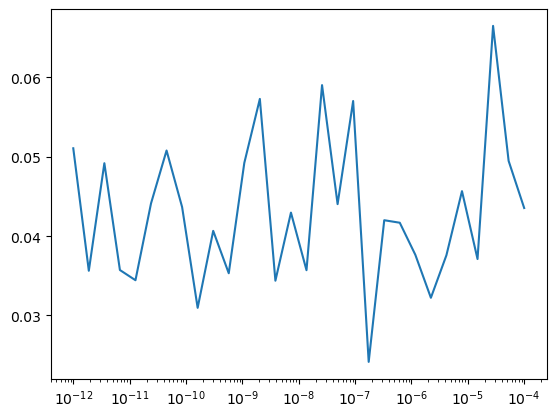

In [98]:
plt.plot(eps2_list, ks_stat2)
plt.xscale('log')